In [1]:
import os
import time
from meidic_vtach_utils.run_on_recommended_cuda import get_cuda_environ_vars as get_vars
os.environ.update(get_vars(select="* -4", force=True))
import pickle
import gzip
import copy
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp
import torchvision
from curriculum_deeplab.data_parameters import DataParamMode
import torchio as tio

import matplotlib.pyplot as plt
from IPython.display import display
import nibabel as nib
from torch.utils.checkpoint import checkpoint

from sklearn.model_selection import KFold

from mdl_seg_class.metrics import dice3d, dice2d
from mdl_seg_class.visualization import visualize_seg
from curriculum_deeplab.mindssc import mindssc

from pathlib import Path

import wandb
import random
import glob
import re
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

print(torch.__version__)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0))


### Recommended gpus on this machine (descending order) ###
  ID  Card name                     Util    Mem free  Cuda             User(s)
----  --------------------------  ------  ----------  ---------------  -------------
   1  NVIDIA GeForce RTX 2080 Ti     0 %   11016 MiB  11.5(495.29.05)
   3  NVIDIA GeForce RTX 2080 Ti     0 %    7633 MiB  11.5(495.29.05)  germer
   2  NVIDIA GeForce RTX 2080 Ti     0 %    3825 MiB  11.5(495.29.05)  grossbroehmer
   0  NVIDIA GeForce RTX 2080 Ti     0 %    2575 MiB  11.5(495.29.05)  schneider

Will apply following mapping

  ID  Card name                       torch
----  --------------------------  --  -------
   1  NVIDIA GeForce RTX 2080 Ti  ->  cuda:0
1.9.0a0+gitdfbd030
8204
NVIDIA GeForce RTX 2080 Ti


In [2]:
def in_notebook():
    try:
        get_ipython().__class__.__name__
        return True
    except NameError:
        return False

if in_notebook:
    THIS_SCRIPT_DIR = os.path.abspath('')
else:
    THIS_SCRIPT_DIR = os.path.dirname(os.path.realpath(__file__))
print(f"Running in: {THIS_SCRIPT_DIR}")

Running in: /share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab


In [5]:
def display_dps(file_paths):
    for _path in file_paths:
        data = torch.load(_path)
        dp_mean_weight = data['data_parameters'].squeeze()
        disturb_flags = data['disturb_flags'] 
        d_ids = data['d_ids'] 
        dataset_idxs = data['dataset_idxs'] 
        _2d_labels = data['labels']
        _2d_modified_labels = data['modified_labels']
        _2d_predictions = data['train_predictions']
        print(f"{'/'.join(_path.split('/')[-2:])} has {len(dp_mean_weight)} parameters.")

        gt_sum = _2d_modified_labels.sum((-2,-1))
        pp_sum = _2d_predictions.sum((-2,-1)).squeeze(1).cpu()
        rgt_sum =  _2d_labels.sum((-2,-1)).cpu()
        intersect = torch.logical_and(_2d_labels, _2d_modified_labels).sum((-2,-1))
        dice = 2*intersect/(rgt_sum+gt_sum+1)

        all_elems = \
            dict(
                disturbed_bool_vect = torch.tensor(disturb_flags).float(),
                gt_sum=gt_sum, 
                dice=dice, 
                pp_sum=pp_sum,
                sqrt_gt_sum=np.sqrt(gt_sum),
                log_gt_sum=np.log(gt_sum+1)+1, # this seems to be right
                e_log_gt_sum=dp_mean_weight/(np.log(gt_sum+np.exp(1))+np.exp(1))
            )
        
        for name, metric in all_elems.items():
            print(name, np.corrcoef(dp_mean_weight.cpu().detach(), metric.detach())[0,1])

        reweighted = dp_mean_weight/(all_elems['e_log_gt_sum'])
        print(f"Corr coeff DP weight {np.corrcoef(dp_mean_weight.detach(), dice.detach())[0,1]:.2f} vs. DP reweight with {name} {np.corrcoef(reweighted.cpu().detach(), dice.detach())[0,1]:.2f}")

        # sel_idxs = reweighted<100
        sel_idxs = range(len(reweighted))
        srtd_reweighted = reweighted[sel_idxs]
        srtd_dice_reweighted = dice[sel_idxs]

        srtd = sorted(zip(srtd_reweighted, srtd_dice_reweighted))
        srtd_reweighted, srtd_dice_reweighted = zip(*srtd)
        srtd_reweighted, srtd_dice_reweighted = torch.stack(srtd_reweighted), torch.stack(srtd_dice_reweighted)

        # Show weights and weights with compensation
        fig, axs = plt.subplots(1,4, figsize=(12, 4), dpi=80)
        sc1 = axs[0].scatter(
            range(len(dp_mean_weight)), 
            dp_mean_weight.cpu().detach(), c=dice,s=1, cmap='plasma');
        sc2 = axs[1].scatter(
            range(len(dp_mean_weight)), 
            reweighted.cpu().detach(), 
            s=1,c=dice, cmap='plasma')
        sc3 = axs[2].scatter(
            range(len(srtd_reweighted)), 
            srtd_reweighted.detach().numpy(), 
            s=1,c=srtd_dice_reweighted, cmap='plasma');
        sc4 = axs[3].scatter(
            range(len(srtd_reweighted)), 
            torch.sigmoid(srtd_reweighted-srtd_reweighted.mean()).detach().numpy(), 
            s=1,c=srtd_dice_reweighted, cmap='plasma');
        plt.colorbar(sc4)
        plt.show()

clear-sweep-1_fold0_epx39/train_label_snapshot.pth has 3566 parameters.


/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


disturbed_bool_vect nan
gt_sum -0.6563845767690817
dice -0.8511781359586339
pp_sum -0.6175732617614215
sqrt_gt_sum -0.8388812601172347
log_gt_sum -0.9715616429355817
e_log_gt_sum 0.9919037987257173
Corr coeff DP weight -0.85 vs. DP reweight with e_log_gt_sum 0.90


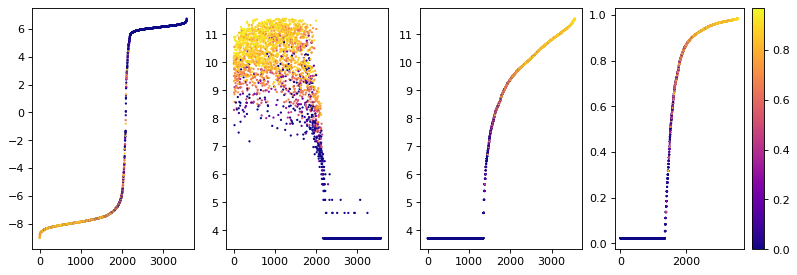

fancy-sweep-2_fold0_epx39/train_label_snapshot.pth has 3566 parameters.
disturbed_bool_vect nan
gt_sum 0.9226623621745232
dice 0.6050958573029569
pp_sum 0.9072332115178018
sqrt_gt_sum 0.8271781672602818
log_gt_sum 0.5998867793048558
e_log_gt_sum 0.822020707256789
Corr coeff DP weight 0.61 vs. DP reweight with e_log_gt_sum 0.90


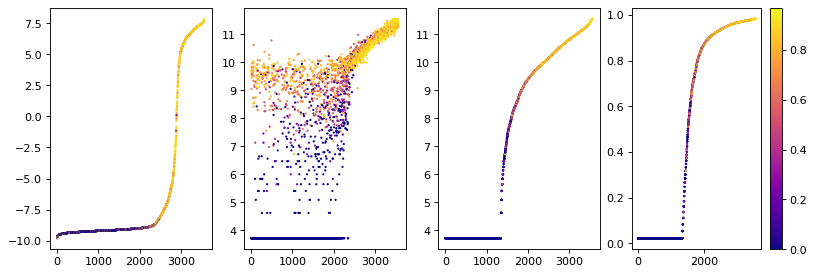

fiery-sweep-3_fold0_epx39/train_label_snapshot.pth has 3566 parameters.
disturbed_bool_vect nan
gt_sum -0.7531536900206629
dice -0.7466233553922185
pp_sum -0.7024397746179245
sqrt_gt_sum -0.8927156661599979
log_gt_sum -0.9841747159647101
e_log_gt_sum 0.9968192760902296
Corr coeff DP weight -0.75 vs. DP reweight with e_log_gt_sum 0.81


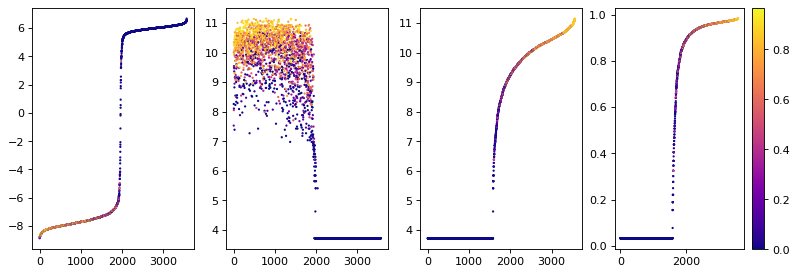

visionary-sweep-4_fold0_epx39/train_label_snapshot.pth has 3566 parameters.
disturbed_bool_vect nan
gt_sum 0.9157012850995357
dice 0.767656262288707
pp_sum 0.8554021118610726
sqrt_gt_sum 0.8335984410029296
log_gt_sum 0.6714484680034318
e_log_gt_sum 0.8692406238619229
Corr coeff DP weight 0.77 vs. DP reweight with e_log_gt_sum 0.81


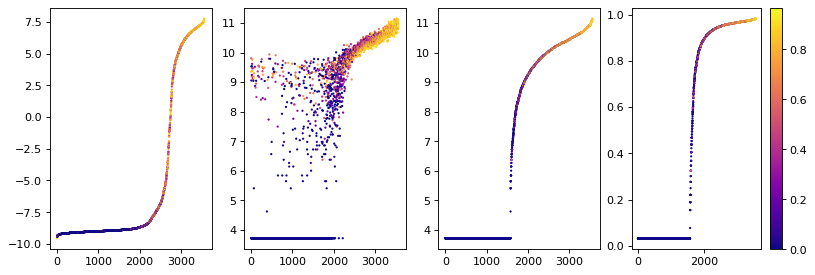

In [6]:
# file_paths = [
#     '/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/crimson-oath-956_fold0_epx39/train_label_snapshot.pth',
#     '/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/_clean-morning-918_fold0_epx39/train_label_snapshot.pth'
# ]

file_paths = glob.glob('./data/output/**/*.pth')

display_dps(file_paths)

In [ ]:
def interpolate_sample(b_image=None, b_label=None, scale_factor=1.,
                       yield_2d=False):
    if yield_2d:
        scale = [scale_factor]*2
        im_mode = 'bilinear'
    else:
        scale = [scale_factor]*3
        im_mode = 'trilinear'

    if b_image is not None:
        b_image = F.interpolate(
            b_image.unsqueeze(1), scale_factor=scale, mode=im_mode, align_corners=True,
            recompute_scale_factor=False
        )
        b_image = b_image.squeeze(1)

    if b_label is not None:
        b_label = F.interpolate(
            b_label.unsqueeze(1).float(), scale_factor=scale, mode='nearest',
            recompute_scale_factor=False
        ).long()
        b_label = b_label.squeeze(1)

    return b_image, b_label
selected_weight = reweighted
data = zip(selected_weight, d_ids, _2d_labels, _2d_modified_labels, _2d_predictions)


samples_sorted = sorted(data, key=lambda tpl: tpl[0])
(dp_weightss, d_idss, _2d_lbl, _2d_ml, _2d_p) = zip(*samples_sorted)

overlay_text_list = [f"id:{d_id} gwd:{instance_p.item():.2f}" \
    for d_id, instance_p in zip(d_idss, dp_weightss)]

visualize_seg(in_type="batch_2D",
    img=interpolate_sample(b_label=torch.stack(_2d_lbl), scale_factor=.5, yield_2d=True)[1].unsqueeze(1),
    seg=interpolate_sample(b_label=4*torch.stack(_2d_p).squeeze(1), scale_factor=.5, yield_2d=True)[1],
    ground_truth=interpolate_sample(b_label=torch.stack(_2d_ml), scale_factor=.5, yield_2d=True)[1],
    crop_to_non_zero_seg=False,
    alpha_seg = .5,
    alpha_gt = .5,
    n_per_row=70,
    overlay_text=overlay_text_list,
    annotate_color=(0,255,255),
    file_path="out_reweight.png",
)

In [ ]:
torch.save(
    {
        'reweighted_weigths': sg_reweighted,
        'd_ids': d_ids 
    }, 
    'fixed_weights.pth'
)


In [ ]:
correction = \
    [
        1.0,
        1/(1+gt_sum).numpy(), 
        1/(1+np.sqrt(gt_sum)).numpy(),
        1/np.log(gt_sum+gt_sum.max().sqrt()).numpy(),
    ]

for crr in correction:
    print(np.corrcoef(torch.tensor(dp_mean_weight).cpu().detach().numpy()*crr, dice)[0,1])


In [ ]:
import glob
import pandas as pd
corrs = {}
def get_corr_coeff(inp):
    return np.corrcoef(torch.tensor(dp_mean_weight).cpu().detach().numpy(), inp)[0,1]

for pth in glob.glob('./data/output/**/*.pth'):
    print(pth)
    data = torch.load(pth)
    dp_mean_weight, *_, d_ids, dataset_idxs, _2d_labels, _2d_modified_labels = data
    gt_sum = _2d_modified_labels.sum((-2,-1))
    pp_sum = _2d_labels.sum((-2,-1))
    intersect = torch.logical_and(_2d_labels, _2d_modified_labels).sum((-2,-1))
    dice = 2*intersect/(pp_sum+gt_sum)
    all_elems = dict(
            gt_sum=get_corr_coeff(gt_sum),
            intersect=get_corr_coeff(intersect),
            pp_sum=get_corr_coeff(pp_sum),
            sqrt=get_corr_coeff(np.sqrt(gt_sum)),
            log=get_corr_coeff(np.log(gt_sum+gt_sum.max().sqrt())), # this seems to be right
            dice=get_corr_coeff(dice)
    )
    corrs[pth.split('/')[-2]] = all_elems
    # break
df = pd.DataFrame(corrs)
df.to_csv('pd.csv')
print(df)
